## Problem 1 - Testing depolarizing noise and ZNE mitigation

With the QAOA parameter combination of problem 1 that achieves the lowest cost, we will try the following experiments:

* Adding depolarizing noise
    * We will add one qubit noise and two qubits noise separately
    * we will combine different one qubit noise values and two qubits noise values
    * The values are taken from ibm_osaka, 23/1/2024
* Trying to mitigate the depolarizing noise with ZNE
    * it will be done for each combination of noise values

We will plot the comparison of the cost history between Ideal VS. Noisy VS. Mitigated for each noise values combination.

### Creating the noise model

In [1]:
from qiskit_aer.noise import (NoiseModel, depolarizing_error)

one_qubit_gates = ['h','rx']
two_qubits_gates = ['rzz']

#create depol. noise
def add_depolarizing_error(noise_model,prob1,prob2):
    noise_model = add_one_qubit_depolarizing_error(noise_model,prob1)
    noise_model = add_two_qubits_depolarizing_error(noise_model,prob2)
    return noise_model

#create 1 qubit depol. noise
def add_one_qubit_depolarizing_error(noise_model,prob):
    error = depolarizing_error(prob, 1)
    noise_model.add_all_qubit_quantum_error(error,one_qubit_gates)
    return noise_model

#create 2 qubits depol.noise
def add_two_qubits_depolarizing_error(noise_model,prob):
    error = depolarizing_error(prob, 2)
    noise_model.add_all_qubit_quantum_error(error, two_qubits_gates)
    return noise_model

noise_model = add_depolarizing_error(NoiseModel(),0.5,0.1)
#display(noise_model.to_dict())

### Uploading experiment1 data for 4-standard-rand-x-Powell

In [2]:
from openqaoa.problems import Knapsack

knapsack_prob = Knapsack(values=[4, 1, 4, 2, 2],weights=[4, 2, 4, 1, 3],weight_capacity=7,penalty=8)
print(knapsack_prob.problem_instance)
knapsack_qubo = knapsack_prob.qubo
knapsack_hamiltonian = knapsack_qubo.hamiltonian

{'problem_type': 'knapsack', 'values': [4, 1, 4, 2, 2], 'weights': [4, 2, 4, 1, 3], 'weight_capacity': 7, 'penalty': 8, 'n_items': 5}


In [3]:
import json
from openqaoa.algorithms import QAOAResult
from openqaoa.qaoa_components import Hamiltonian

with open('../../exp1/problem1/prob1_4-standard-rand-x-Powell.json', 'r') as file:
    data = json.load(file)
cost_hamiltonian = data['cost_hamiltonian']
cost_hamiltonian = Hamiltonian.classical_hamiltonian(knapsack_qubo.terms,cost_hamiltonian['coeffs'],cost_hamiltonian['constant'])

result = QAOAResult.from_dict(data,cost_hamiltonian)

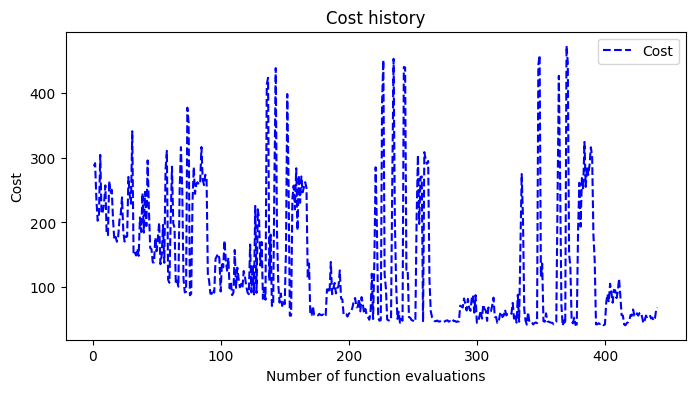

In [4]:
result.plot_cost(figsize=(8,4))

### Running the same experiment with noise and with ZNE

0.0002594 ,  0.008397
    QAOA
    QAOA+noise
    QAOA+noise+ZNE
0.0002594 ,  0.08397
    QAOA
    QAOA+noise
    QAOA+noise+ZNE
0.002594 ,  0.008397
    QAOA
    QAOA+noise
    QAOA+noise+ZNE
0.002594 ,  0.08397
    QAOA
    QAOA+noise
    QAOA+noise+ZNE
0.02594 ,  0.008397
    QAOA
    QAOA+noise
    QAOA+noise+ZNE
0.02594 ,  0.08397
    QAOA
    QAOA+noise
    QAOA+noise+ZNE


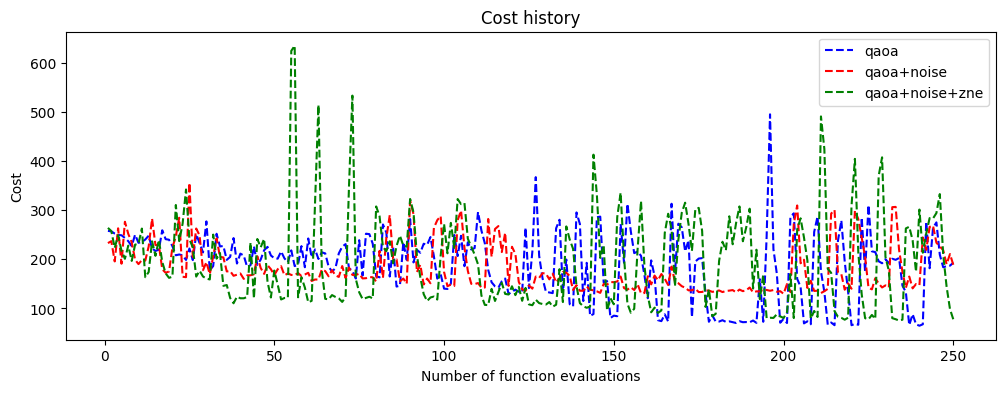

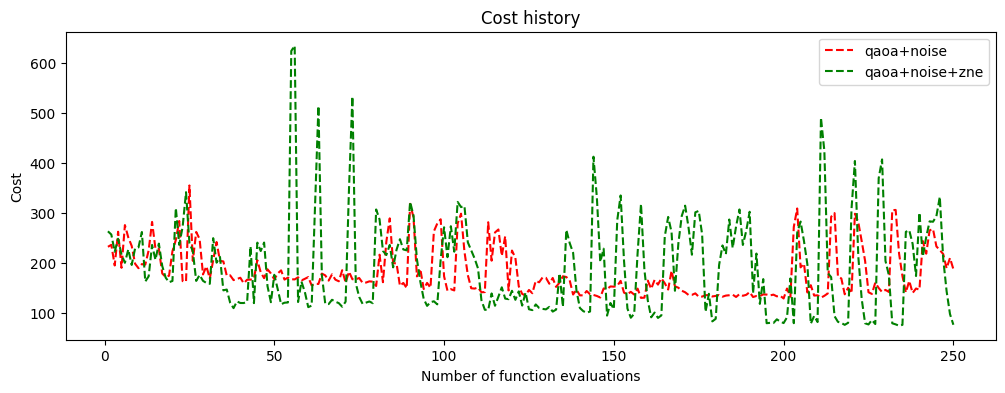

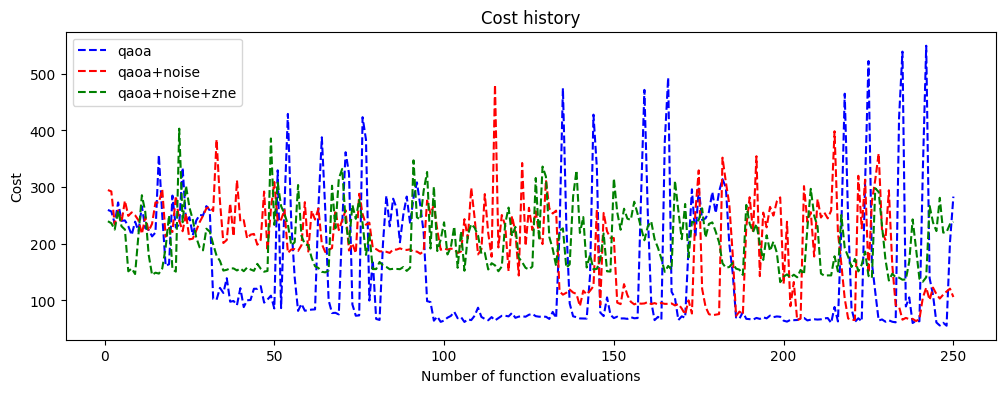

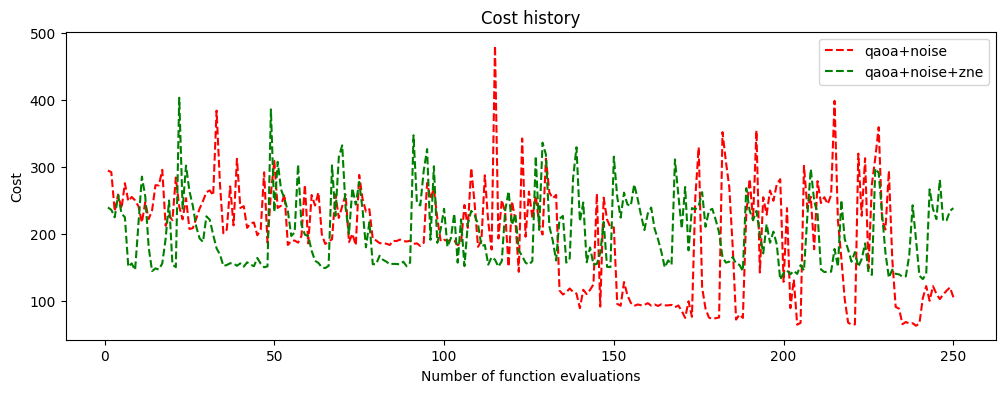

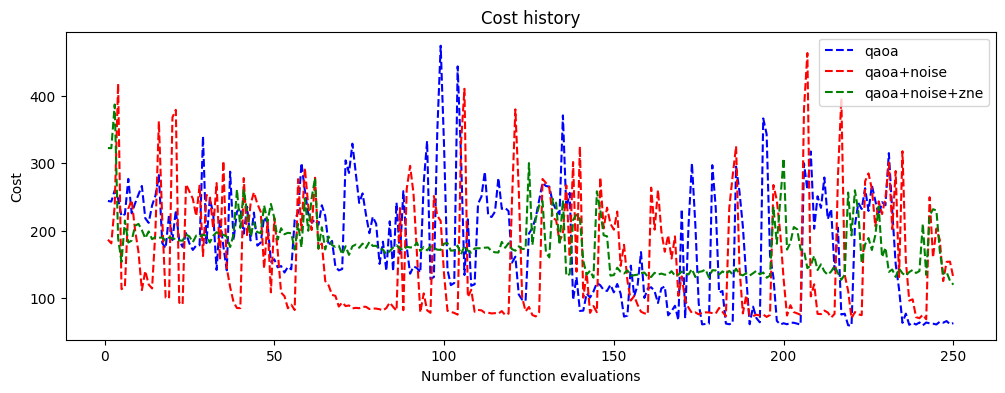

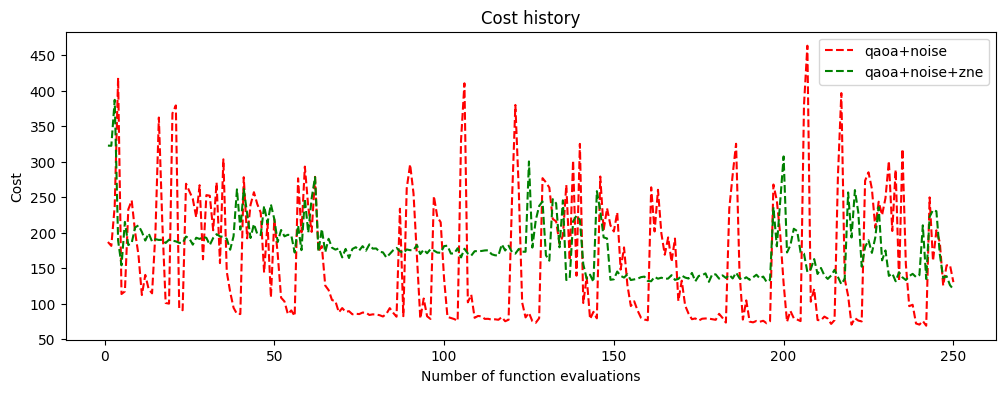

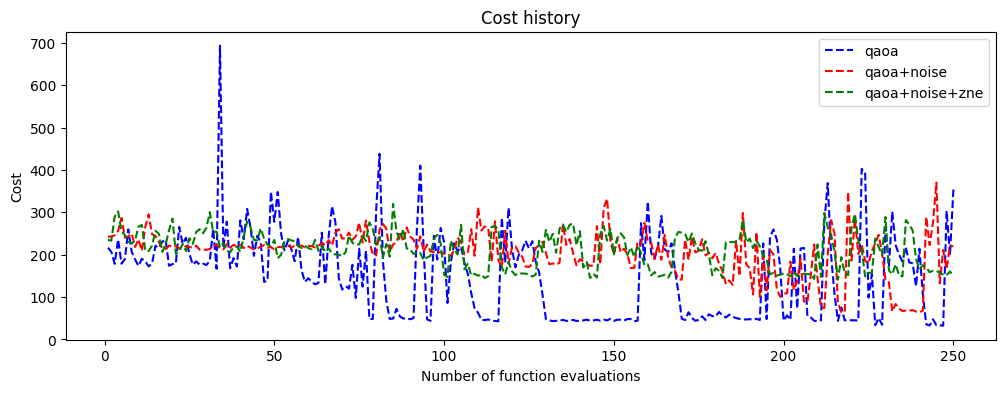

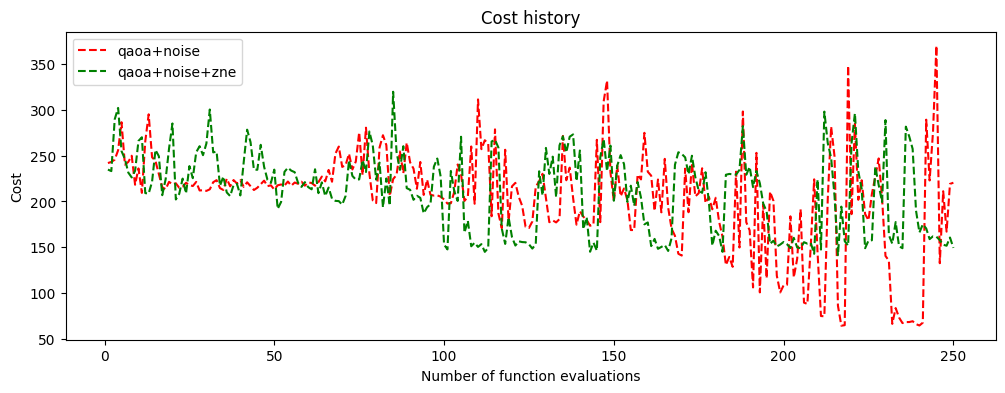

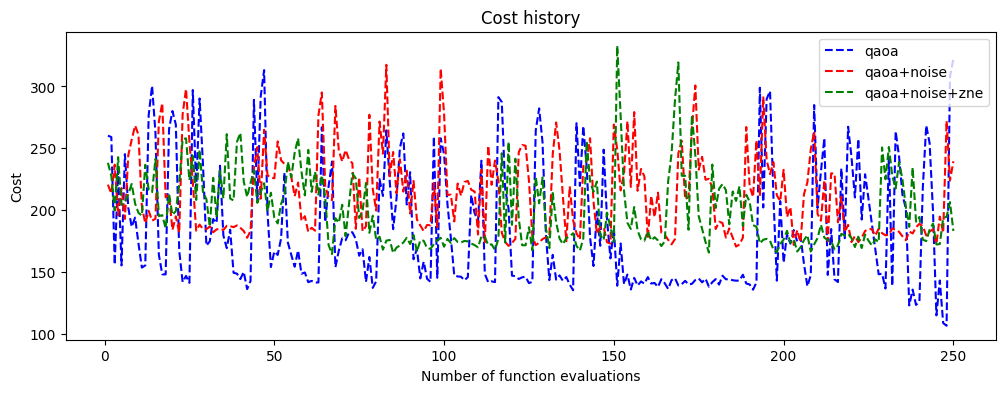

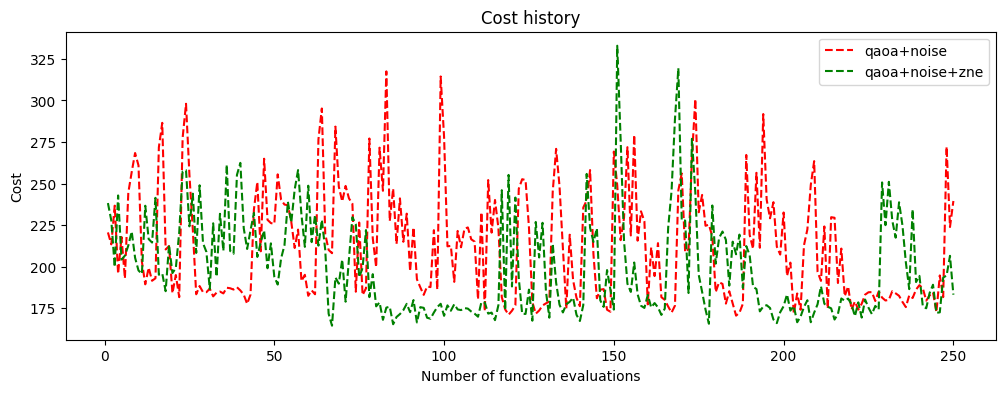

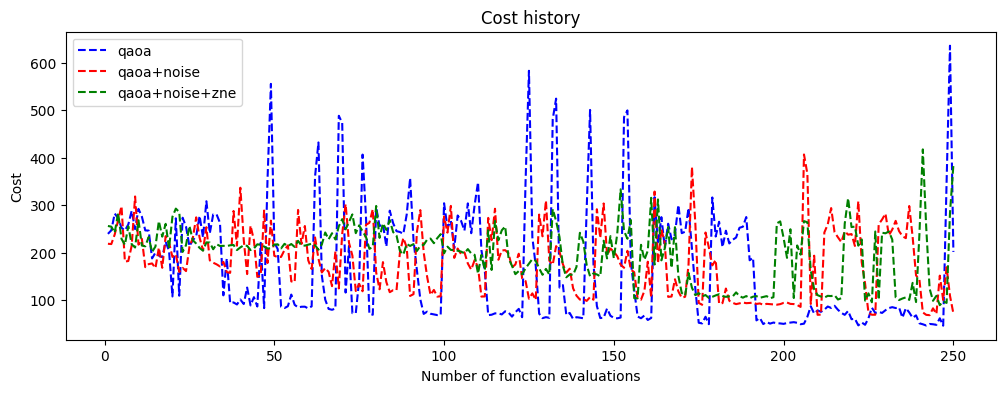

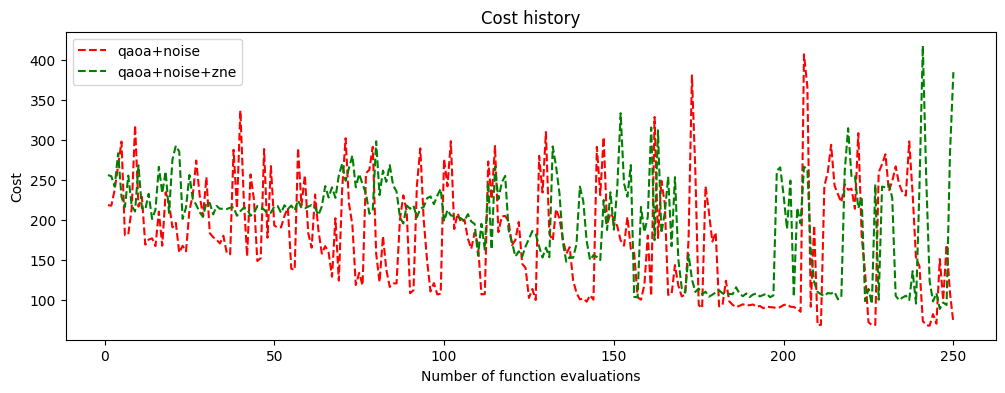

In [10]:
from tqdm import tqdm
from openqaoa.backends import create_device
from openqaoa import QAOA
from openqaoa.utilities import ground_state_hamiltonian
import matplotlib.pyplot as plt
import json


#first value took from ibm_osaka, Median SX error, 23/1/2024
one_qubit_noises = [2.594e-4,2.594e-3,2.594e-2]
#first value took from ibm_osaka, Median ECR error, 23/1/2024
two_qubits_noises = [8.397e-3,8.397e-2]

for one_qubit_noise in one_qubit_noises:
    for two_qubits_noise in two_qubits_noises:
        print(one_qubit_noise,', ',two_qubits_noise)
        noise_model = add_depolarizing_error(NoiseModel(),one_qubit_noise,two_qubits_noise)
        qiskit_device = create_device(location='ibmq', name='ibmq_qasm_simulator')
        #qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
        print('    QAOA')
        #QAOA
        q1 = QAOA()
        q1.set_device(qiskit_device)
        q1.set_circuit_properties(p=4, param_type='standard', init_type='rand', mixer_hamiltonian='x')
        q1.set_backend_properties(n_shots=5000, seed_simulator=1)
        q1.set_classical_optimizer(method='Powell', maxfev=250,maxiter=200, tol=0.01,
        optimization_progress=True, cost_progress=True, parameter_log=True)
        q1.compile(knapsack_qubo)
        q1.optimize()
        opt_results1 = q1.result
         #export jsons
        with open('prob1_4-standard-rand-x-Powell_%s-%s_ideal.json'% (str(one_qubit_noise),str(two_qubits_noise)), 'w') as archivo:
            json.dump(opt_results1.asdict(), archivo)
        
        print('    QAOA+noise')
        #QAOA+noise
        q2 = QAOA()
        q2.set_device(qiskit_device)
        q2.set_circuit_properties(p=4, param_type='standard', init_type='rand', mixer_hamiltonian='x')
        q2.set_backend_properties(n_shots=5000, seed_simulator=1, noise_model=noise_model)
        q2.set_classical_optimizer(method='Powell', maxfev=250, maxiter=200, tol=0.01,
        optimization_progress=True, cost_progress=True, parameter_log=True)
        q2.compile(knapsack_qubo)
        q2.optimize()
        opt_results2 = q2.result
        with open('prob1_4-standard-rand-x-Powell_%s-%s_noisy.json'% (str(one_qubit_noise),str(two_qubits_noise)), 'w') as archivo:
            json.dump(opt_results2.asdict(), archivo)

        print('    QAOA+noise+ZNE')
        #QAOA+noise+ZNE
        q3 = QAOA()
        q3.set_device(qiskit_device)
        q3.set_circuit_properties(p=4, param_type='standard', init_type='rand', mixer_hamiltonian='x')
        q3.set_backend_properties(n_shots=5000, seed_simulator=1, noise_model=noise_model)
        q3.set_classical_optimizer(method='Powell', maxfev=250, maxiter=200, tol=0.01,
        optimization_progress=True, cost_progress=True, parameter_log=True)
        q3.set_error_mitigation_properties(
        error_mitigation_technique='mitiq_zne',n_batches=4,calibration_data_location="caldata.json"
        )
        q3.compile(knapsack_qubo)
        q3.optimize()
        opt_results3 = q3.result
        with open('prob1_4-standard-rand-x-Powell_%s-%s_mitigated.json'% (str(one_qubit_noise),str(two_qubits_noise)), 'w') as archivo:
            json.dump(opt_results3.asdict(), archivo)
        
        fig, ax = plt.subplots(figsize=(12,4))
        opt_results1.plot_cost(color='blue',label='qaoa',ax=ax)
        opt_results2.plot_cost(color='red',label='qaoa+noise',ax=ax)
        opt_results3.plot_cost(color='green',label='qaoa+noise+zne',ax=ax)
        plt.savefig("prob1_4-standard-rand-x-Powell_%s-%s_ideal-noise-ZNE.png"% (str(one_qubit_noise),str(two_qubits_noise)), bbox_inches='tight')

        fig, ax = plt.subplots(figsize=(12,4))
        opt_results2.plot_cost(color='red',label='qaoa+noise',ax=ax)
        opt_results3.plot_cost(color='green',label='qaoa+noise+zne',ax=ax)
        plt.savefig("prob1_4-standard-rand-x-Powell_%s-%s_noise-ZNE.png"% (str(one_qubit_noise),str(two_qubits_noise)), bbox_inches='tight')